In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text


In [5]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    return text


In [3]:
from langdetect import detect

# Function to detect the language of text
def detect_language(text):
    try:
        return detect(text)
    except:
        return print("Error cannot detect language")

# load dataset

In [ ]:
hermes_process_state = pd.read_csv('dataset/hermes_process_states.csv')
hermes_process_state.head()

In [ ]:
knowledge_tools = pd.read_csv('dataset/knowledge_tools.csv')
knowledge_tools.head()

In [ ]:
knowledge_analysis_categories = pd.read_csv('dataset/knowledge_analysis_categories.csv')

knowledge_analysis_categories.sort_values(by='escalation_status', ascending=False, inplace=True)
knowledge_analysis_categories

In [ ]:
hermes_process_logs = pd.read_csv('dataset/hermes_process_logs.csv')
hermes_process_logs.head()

In [ ]:
hermes_process_logs.info()

In [ ]:
# check null values
hermes_process_logs.isnull().sum()

In [ ]:
# drop all null value
hermes_process_logs.dropna(inplace=True)

In [ ]:
# categoory count
hermes_process_logs['category_name'].value_counts()

In [ ]:
# count anget_name
hermes_process_logs['agent_name'].value_counts()

In [ ]:
# delete other agent_name except 'Hosting'
hermes_process_logs = hermes_process_logs[hermes_process_logs['agent_name'] == 'Hosting']

hermes_process_logs['category_name'].value_counts()

In [ ]:
hermes_process_logs['state_name'].value_counts()

## filter by category

In [ ]:
# Step 1: Make a copy of the original DataFrame
hermes_process_copy = hermes_process_logs.copy()

# Step 2: Drop rows where 'category_name' starts with 'query'
hermes_process_copy = hermes_process_copy[~hermes_process_copy['category_name'].str.startswith('query')]

# Step 3: Drop rows where 'category_name' starts with 'information'
hermes_process_copy = hermes_process_copy[~hermes_process_copy['category_name'].str.startswith('information')]

# Step 4: Check unique 'category_name' values in the resulting DataFrame
unique_category_names = hermes_process_copy['category_name'].unique()
unique_category_names

In [ ]:
# check form the data on last message if it contain the word 'request'
request = hermes_process_copy['category_name'].str.contains('request').sum()
print(request ==len(hermes_process_copy))

In [ ]:
# new dataframe contain only last message and category_name
message = hermes_process_logs[['last_message', 'category_name']]

In [ ]:
# drop duplicate message for the last message
message.duplicated().sum()
message = message.drop_duplicates().copy()

In [ ]:
message['category_name'].value_counts()

In [ ]:
# Apply preprocessing to 'last_message' column
message['last_message_clean'] = message['last_message'].apply(preprocess_text)

# Drop messages without any alphabet characters
message = message[message['last_message_clean'].str.match('.*[a-zA-Z].*')]

# Reset index after dropping rows
message.reset_index(drop=True, inplace=True)

# Display the preprocessed DataFrame
message.head()


In [ ]:
# Extracting features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(message['last_message_clean'])

In [ ]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=message['category_name'])

# Group by category and sum the TF-IDF scores for each word
tfidf_sums = tfidf_df.groupby(tfidf_df.index).sum()

In [ ]:
# Get the top keywords for each category
top_keywords = {}
for category in tfidf_sums.index:
    top_keywords[category] = tfidf_sums.loc[category].sort_values(ascending=False).head(5).index.tolist()

# Display top keywords for each category
for category, keywords in top_keywords.items():
    print(f"Category: {category}")
    print("Top keywords:", ", ".join(keywords))

# load new clean dataset

In [ ]:
# load request csv into dataframe
request = pd.read_csv('dataset/request.csv')
request.head() 

In [ ]:
# detect language of the of last message
request['language'] = request['last_message'].apply(detect_language)

In [ ]:
result = request.groupby(['language', 'category_name']).size().reset_index(name='count')
# Pivot the table to get languages as rows, category names as columns, and counts as values
pivot_table = result.pivot_table(index='language', columns='category_name', values='count', fill_value=0)
pivot_table


In [ ]:
# only keep the rows where the 'language' column is 'en'
english_requests = request[request['language'] == 'en']
english_requests.head()

In [ ]:
english_requests['category_name'].value_counts()

In [ ]:
onsite_requests = english_requests[english_requests['category_name'] == 'request_onsite']

In [ ]:
onsite_requests.head()

In [ ]:
# Truncate the strings in the specified column to the first 40 characters
column_name = 'information'
onsite_requests[column_name] = onsite_requests[column_name].astype(str).str[:50]

# Find the unique values in the truncated column
unique_values = onsite_requests[column_name].unique()

# Print or save the unique values
print(unique_values)

In [ ]:
# preprocess the 'last_message' column 
english_requests['last_message_clean'] = english_requests['last_message'].apply(preprocess_text)

In [ ]:
english_requests.head()
columns = ['category_name', 'last_message_clean']
english_requests = english_requests[columns]

In [ ]:
english_requests

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features using TF-IDF
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(english_requests['last_message_clean'])

# find the top keywords for each category
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=english_requests['category_name'])

tfidf_sums = tfidf_df.groupby(tfidf_df.index).sum()

In [ ]:
top_keywords = {}
for category in tfidf_sums.index:
    top_keywords[category] = tfidf_sums.loc[category].sort_values(ascending=False).head(10).index.tolist()
    
# Display top keywords for each category
for category, keywords in top_keywords.items():
    print(f"Category: {category}")
    print("Top keywords:", ", ".join(keywords))

# bangun model klasifikasi

In [ ]:
model_df = pd.read_csv('dataset/model_df.csv')

# random sample of the DataFrame
model_df.sample(5)

In [ ]:
# set x and y where x is the 'last_message' column and y is the 'category_name' column
X = model_df['last_message']
y = model_df['category_name']

In [ ]:
y.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 2: Vectorization
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Step 4: Choose a Classifier
classifier = SVC(kernel='linear')

# Step 5: Train the Model
classifier.fit(X_train, y_train)

# Step 6: Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 7: Hyperparameter Tuning (optional)
# You can use techniques like GridSearchCV or RandomizedSearchCV to find the best hyperparameters.

In [ ]:
# Example new input message
new_message = "there is a leeakage in toilet, please send someone to fix it"

# Step 1: Preprocess the new message
new_message_vectorized = vectorizer.transform([new_message])

# Step 2: Predict the category using the trained classifier
predicted_category = classifier.predict(new_message_vectorized)

print("Predicted category:", predicted_category)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to make them of equal length
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Encoding labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
num_classes

In [ ]:
import tensorflow as tf

# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train_encoded, validation_data=(X_test_pad, y_test_encoded), epochs=10, batch_size=64)


In [ ]:
# preprocess the new message
new_message = "there is a leeakage in toilet, please send someone to fix it"

# Convert the new message to a sequence
new_message_seq = tokenizer.texts_to_sequences([new_message])

# Pad the sequence
new_message_pad = pad_sequences(new_message_seq, maxlen=max_len, padding='post')

# Predict the category
predicted_category = model.predict(new_message_pad)
predicted_category = label_encoder.inverse_transform([np.argmax(predicted_category)])

print("Predicted category:", predicted_category[0])


In [ ]:
# save the model as h5 file
model.save('model.h5')

# try new model

In [17]:
data = pd.read_csv('dataset/model_df2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58761 entries, 0 to 58760
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   last_message   58761 non-null  object
 1   category_name  58761 non-null  object
dtypes: object(2)
memory usage: 918.3+ KB


In [18]:
data['cleaned_message'] = data['last_message'].apply(preprocess_text)

In [19]:
# Create binary labels
data['is_onsite'] = data['category_name'] == 'request_onsite'

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58761 entries, 0 to 58760
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   last_message     58761 non-null  object
 1   category_name    58761 non-null  object
 2   cleaned_message  58761 non-null  object
 3   is_onsite        58761 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 1.4+ MB


In [21]:
# find average length of the message
data['message_length'] = data['cleaned_message'].apply(len)

data['message_length'].describe()

count    58761.000000
mean        93.509624
std        125.545457
min          0.000000
25%         26.000000
50%         59.000000
75%        115.000000
max       1591.000000
Name: message_length, dtype: float64

In [30]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_message'])

X = tokenizer.texts_to_sequences(data['cleaned_message'])
X = pad_sequences(X, maxlen=200, padding='post')

y = data['is_onsite'].astype(int)


In [32]:
import pickle

with open('tokenizer_config.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)



In [23]:
y.value_counts()

is_onsite
0    49674
1     9087
Name: count, dtype: int64

In [24]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [25]:
len(X_res), len(y_res)

(99348, 99348)

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
len(X_train), len(X_test)


(79478, 19870)

In [27]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          500000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 617377 (2.36 MB)
Trainable params: 617377 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
994/994 [==============================] - 1107s 1s/step - loss: 0.6944 - accuracy: 0.4987 - val_loss: 0.6930 - val_accuracy: 0.5056
Epoch 2/10
994/994 [==============================] - 929s 935ms/step - loss: 0.6946 - accuracy: 0.5025 - val_loss: 0.6952 - val_accuracy: 0.5057
Epoch 3/10
994/994 [==============================] - 930s 935ms/step - loss: 0.6935 - accuracy: 0.5050 - val_loss: 0.6928 - val_accuracy: 0.4951
Epoch 4/10
994/994 [==============================] - 951s 957ms/step - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6927 - val_accuracy: 0.5056
Epoch 5/10
994/994 [==============================] - 1251s 1s/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6926 - val_accuracy: 0.5056
Epoch 6/10
994/994 [==============================] - 1663s 2s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5056
Epoch 7/10
994/994 [==============================] - 1946s 2s/step - loss: 0.6931 - accuracy: 0.4998 - val_loss: 0.6927 - val_acc

In [29]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


621/621 [==============================] - 45s 73ms/step - loss: 0.2562 - accuracy: 0.8967
Test Accuracy: 0.8967287540435791


In [30]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


621/621 [==============================] - 43s 68ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     10049
           1       0.88      0.92      0.90      9821

    accuracy                           0.90     19870
   macro avg       0.90      0.90      0.90     19870
weighted avg       0.90      0.90      0.90     19870

ROC-AUC: 0.8969496265975165


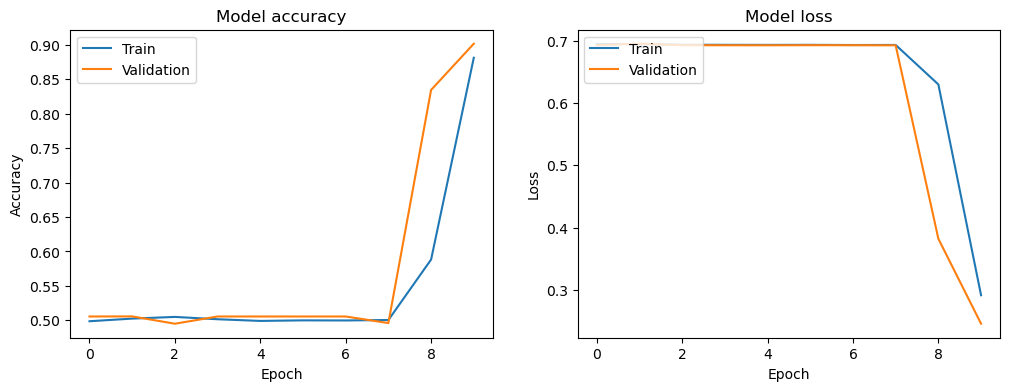

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [32]:
# save model
model.save('model/onsite_request_model.h5')

c:\Users\ahini\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# test with new message
message = "there is a leeakage in toilet, please send someone to fix it"

# Preprocess the new message
message = preprocess_text(message)

# Tokenize the new message
message_seq = tokenizer.texts_to_sequences([message])
message_pad = pad_sequences(message_seq, maxlen=200, padding='post')

# Predict the category
prediction = model.predict(message_pad)
prediction = 'Onsite' if prediction > 0.5 else 'Not Onsite'

print(f"The message is predicted to be: {prediction}")

1/1 [==============================] - 0s 46ms/step
The message is predicted to be: Onsite


In [24]:
def inference(message, tokenizer, model, maxlen=200):
    """
    Perform inference to predict the category of the message.

    Parameters:
    - message: str, the input message
    - tokenizer: the tokenizer used to preprocess the text
    - model: the trained model used for prediction
    - maxlen: int, the maximum length of the sequence for padding (default: 200)

    Returns:
    - str, the predicted category ('Onsite' or 'Not Onsite')
    """
    # Preprocess the new message
    message = preprocess_text(message)

    # Tokenize the new message
    message_seq = tokenizer.texts_to_sequences([message])
    message_pad = pad_sequences(message_seq, maxlen=maxlen, padding='post')

    # Predict the category
    prediction = model.predict(message_pad)
    prediction = 'Onsite' if prediction > 0.5 else 'Not Onsite'

    return prediction




In [35]:
# Test the inference function
message = "My room is very dirty, please clean it."
prediction = inference(message, tokenizer, model)
print(f"The message is predicted to be: {prediction}")

1/1 [==============================] - 0s 42ms/step
The message is predicted to be: Onsite


In [36]:
message = "Is there a car today, I want to go to the airport?"
prediction = inference(message, tokenizer, model)
print(f"The message is predicted to be: {prediction}")

1/1 [==============================] - 0s 43ms/step
The message is predicted to be: Not Onsite


In [37]:
messages = [
    # Category: request_onsite
    "The air conditioner in the villa is not working, can someone come and fix it?",
    "There's a leak in the bathroom, can you send maintenance?",
    "The lights in the hallway are flickering, could you send someone to check it?",

    # Category: request_extra_service
    "Can we get an extra bed in our room?",
    "I would like to request a daily cleaning service.",
    "Can you arrange for a birthday cake in our room?",

    # Category: query_property_information
    "Can you tell me more about the facilities at the hotel?",
    "What amenities are available in the villa?",
    "Is there a swimming pool at the property?",

    # Category: request_early_check_in
    "Is it possible to check in earlier, around 10 AM?",
    "Can we get an early check-in for our booking tomorrow?",
    "We arrive early in the morning, can we check in at 8 AM?",

    # Category: request_extension
    "Can we extend our stay by two more nights?",
    "Is it possible to extend our booking until next Friday?",
    "We'd like to stay an extra day, can you accommodate that?",

    # Category: information_guest_id
    "My guest ID is 12345, please confirm my booking.",
    "Here is my guest ID: 67890, can you check my reservation?"
]

# Perform inference for each message
results = []
for message in messages:
    prediction = inference(message, tokenizer, model)
    results.append((message, prediction))

# Display the results
for message, prediction in results:
    print(f"Message: {message}")
    print(f"Predicted Category: {prediction}")
    print()

1/1 [==============================] - 0s 37ms/step
Message: The air conditioner in the villa is not working, can someone come and fix it?
Predicted Category: Onsite

Message: There's a leak in the bathroom, can you send maintenance?
Predicted Category: Onsite

Message: The lights in the hallway are flickering, could you send someone to check it?
Predicted Category: Not Onsite

Message: Can we get an extra bed in our room?
Predicted Category: Not Onsite

Message: I would like to request a daily cleaning service.
Predicted Category: Not Onsite

Message: Can you arrange for a birthday cake in our room?
Predicted Category: Not Onsite

Message: Can you tell me more about the facilities at the hotel?
Predicted Category: Not Onsite

Message: What amenities are available in the villa?
Predicted Category: Not Onsite

Message: Is there a swimming pool at the property?
Predicted Category: Onsite

Message: Is it possible to check in earlier, around 10 AM?
Predicted Category: Not Onsite

Message: 

In [25]:
message ="my room’s door is broken, help me! "
prediction = inference(message, tokenizer, model)
print(f"The message is predicted to be: {prediction}")

NameError: name 'model' is not defined

In [31]:
# load model
from tensorflow.keras.models import load_model

model = load_model('onsite_request_model.h5')

message ="my room’s door is broken, help me! "
prediction = inference(message, tokenizer, model)
print(f"The message is predicted to be: {prediction}")

1/1 [==============================] - 0s 256ms/step
The message is predicted to be: Onsite
